# Part 1: Hidden Markov Model for Hangman

This notebook implements the HMM component of the Hangman AI agent.

## Approach

### HMM Design:
- **Hidden States**: Letter positions in words (each position can have any letter a-z)
- **Emissions**: The observed pattern (masked word with known letters and blanks)
- **Strategy**: We'll use a position-based character-level HMM that learns:
  - Letter frequency distributions at each position
  - Transition probabilities between consecutive letters
  - Contextual patterns based on known letters

### Implementation:
1. Train separate models for different word lengths
2. Learn letter frequency and position-based probabilities
3. Use Viterbi-like decoding to estimate probabilities for blanks
4. Combine multiple information sources for robust predictions

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import pickle
import re
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Explore the Corpus

In [3]:
# Load the corpus
with open('data/corpus.txt', 'r') as f:
    corpus = [word.strip().lower() for word in f.readlines()]

print(f"Total words in corpus: {len(corpus)}")
print(f"Sample words: {corpus[:10]}")

# Analyze word length distribution
word_lengths = [len(word) for word in corpus]
length_dist = Counter(word_lengths)

print(f"\nWord length distribution:")
for length in sorted(length_dist.keys())[:15]:
    print(f"Length {length}: {length_dist[length]} words")

Total words in corpus: 50000
Sample words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']

Word length distribution:
Length 1: 46 words
Length 2: 84 words
Length 3: 388 words
Length 4: 1169 words
Length 5: 2340 words
Length 6: 3755 words
Length 7: 5111 words
Length 8: 6348 words
Length 9: 6808 words
Length 10: 6465 words
Length 11: 5452 words
Length 12: 4292 words
Length 13: 3094 words
Length 14: 2019 words
Length 15: 1226 words


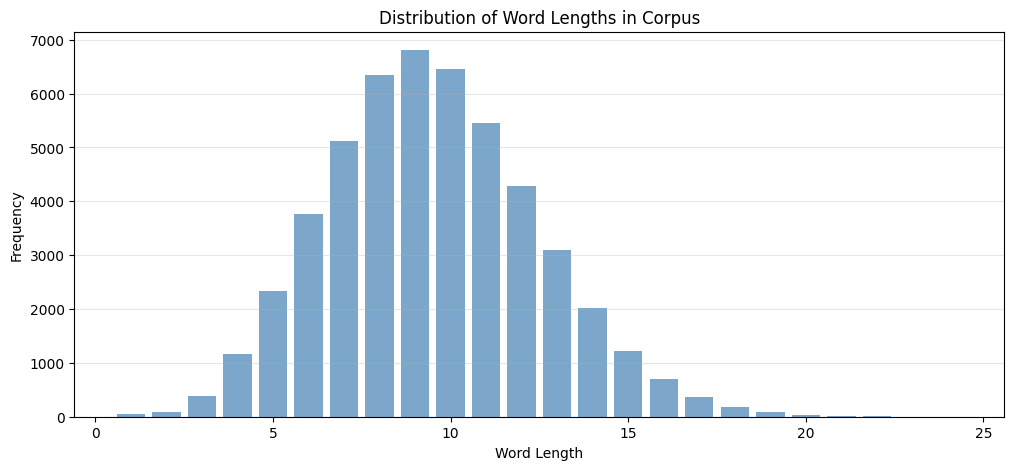

Min length: 1, Max length: 24
Mean length: 9.50
Median length: 9


In [4]:
# Visualize word length distribution
plt.figure(figsize=(12, 5))
lengths = list(length_dist.keys())
counts = [length_dist[l] for l in lengths]
plt.bar(lengths, counts, color='steelblue', alpha=0.7)
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths in Corpus')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Min length: {min(lengths)}, Max length: {max(lengths)}")
print(f"Mean length: {np.mean(word_lengths):.2f}")
print(f"Median length: {np.median(word_lengths):.0f}")

## 2. HMM Model Class

We'll build an HMM that learns:
1. **Position-based letter frequencies** - What letters appear at each position
2. **Transition probabilities** - What letters follow other letters
3. **Pattern matching** - Words matching the current game state
4. **N-gram patterns** - Common letter sequences

In [5]:
class HangmanHMM:
    """
    Hidden Markov Model for Hangman letter prediction.
    
    Hidden States: Letters at each position in the word
    Emissions: The masked pattern we observe (e.g., '_pp_e')
    """
    
    def __init__(self):
        self.corpus_by_length = defaultdict(list)
        self.position_freq = {}  # Position-based letter frequencies
        self.transition_matrix = {}  # Letter transition probabilities
        self.letter_freq = Counter()  # Overall letter frequencies
        self.bigram_freq = defaultdict(Counter)  # Bigram frequencies
        self.trigram_freq = defaultdict(Counter)  # Trigram frequencies
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')
        
    def train(self, corpus: List[str]):
        """
        Train the HMM on the corpus.
        """
        print("Training HMM...")
        
        # Organize corpus by word length
        for word in corpus:
            word = word.lower()
            self.corpus_by_length[len(word)].append(word)
        
        print(f"Organized {len(corpus)} words into {len(self.corpus_by_length)} length groups")
        
        # Train position-based frequencies for each word length
        for length, words in self.corpus_by_length.items():
            self.position_freq[length] = defaultdict(Counter)
            
            for word in words:
                # Position frequencies
                for pos, char in enumerate(word):
                    self.position_freq[length][pos][char] += 1
                    self.letter_freq[char] += 1
                
                # Bigram frequencies
                for i in range(len(word) - 1):
                    self.bigram_freq[word[i]][word[i+1]] += 1
                
                # Trigram frequencies
                for i in range(len(word) - 2):
                    self.trigram_freq[word[i:i+2]][word[i+2]] += 1
        
        # Normalize to probabilities
        self._normalize_frequencies()
        
        print("HMM training complete!")
        print(f"Total unique letters: {len(self.letter_freq)}")
        print(f"Most common letters: {self.letter_freq.most_common(10)}")
    
    def _normalize_frequencies(self):
        """
        Convert frequency counts to probabilities.
        """
        # Normalize position frequencies
        for length in self.position_freq:
            for pos in self.position_freq[length]:
                total = sum(self.position_freq[length][pos].values())
                for char in self.position_freq[length][pos]:
                    self.position_freq[length][pos][char] /= total
        
        # Normalize bigram frequencies
        for first_char in self.bigram_freq:
            total = sum(self.bigram_freq[first_char].values())
            for second_char in self.bigram_freq[first_char]:
                self.bigram_freq[first_char][second_char] /= total
        
        # Normalize trigram frequencies
        for bigram in self.trigram_freq:
            total = sum(self.trigram_freq[bigram].values())
            for char in self.trigram_freq[bigram]:
                self.trigram_freq[bigram][char] /= total
    
    def predict_letter_probabilities(self, masked_word: str, guessed_letters: set) -> Dict[str, float]:
        """
        Given a masked word (e.g., '_pp_e') and guessed letters,
        return probability distribution over remaining letters.
        
        Args:
            masked_word: Current state of the word (e.g., '_pp_e')
            guessed_letters: Set of already guessed letters
        
        Returns:
            Dictionary mapping each unguessed letter to its probability
        """
        word_length = len(masked_word)
        remaining_letters = self.alphabet - guessed_letters
        
        # Initialize probabilities
        letter_probs = {letter: 0.0 for letter in remaining_letters}
        
        # Strategy 1: Pattern matching - find words that match the pattern
        matching_words = self._find_matching_words(masked_word, guessed_letters)
        pattern_probs = self._get_letter_distribution(matching_words, remaining_letters)
        
        # Strategy 2: Position-based probabilities
        position_probs = self._get_position_based_probs(masked_word, remaining_letters)
        
        # Strategy 3: Contextual n-gram probabilities
        ngram_probs = self._get_ngram_probs(masked_word, remaining_letters)
        
        # Strategy 4: Overall frequency
        freq_probs = self._get_frequency_probs(remaining_letters)
        
        # Combine strategies with weights
        # Pattern matching is most reliable when we have matches
        if len(matching_words) > 0:
            weights = [0.5, 0.2, 0.2, 0.1]  # Pattern, position, ngram, frequency
        else:
            weights = [0.0, 0.4, 0.3, 0.3]  # No pattern matches
        
        for letter in remaining_letters:
            letter_probs[letter] = (
                weights[0] * pattern_probs.get(letter, 0) +
                weights[1] * position_probs.get(letter, 0) +
                weights[2] * ngram_probs.get(letter, 0) +
                weights[3] * freq_probs.get(letter, 0)
            )
        
        # Normalize
        total = sum(letter_probs.values())
        if total > 0:
            letter_probs = {k: v/total for k, v in letter_probs.items()}
        
        return letter_probs
    
    def _find_matching_words(self, masked_word: str, guessed_letters: set) -> List[str]:
        """
        Find all words in corpus that match the current pattern.
        """
        word_length = len(masked_word)
        
        if word_length not in self.corpus_by_length:
            return []
        
        matching_words = []
        
        for word in self.corpus_by_length[word_length]:
            # Check if word matches the pattern
            if self._word_matches_pattern(word, masked_word, guessed_letters):
                matching_words.append(word)
        
        return matching_words
    
    def _word_matches_pattern(self, word: str, pattern: str, guessed_letters: set) -> bool:
        """
        Check if a word matches the masked pattern.
        """
        if len(word) != len(pattern):
            return False
        
        for w_char, p_char in zip(word, pattern):
            if p_char != '_':
                # Known position must match
                if w_char != p_char:
                    return False
            else:
                # Unknown position must not be a guessed letter
                if w_char in guessed_letters:
                    return False
        
        return True
    
    def _get_letter_distribution(self, words: List[str], remaining_letters: set) -> Dict[str, float]:
        """
        Get letter distribution from a list of words.
        """
        if not words:
            return {letter: 0.0 for letter in remaining_letters}
        
        letter_counts = Counter()
        for word in words:
            for char in set(word):  # Count each letter once per word
                if char in remaining_letters:
                    letter_counts[char] += 1
        
        total = sum(letter_counts.values())
        if total == 0:
            return {letter: 0.0 for letter in remaining_letters}
        
        return {letter: letter_counts.get(letter, 0) / total for letter in remaining_letters}
    
    def _get_position_based_probs(self, masked_word: str, remaining_letters: set) -> Dict[str, float]:
        """
        Get probabilities based on position-specific letter frequencies.
        """
        word_length = len(masked_word)
        letter_scores = Counter()
        
        if word_length not in self.position_freq:
            return {letter: 1.0/len(remaining_letters) for letter in remaining_letters}
        
        # For each blank position, add the probability of each letter
        for pos, char in enumerate(masked_word):
            if char == '_':
                for letter in remaining_letters:
                    if pos in self.position_freq[word_length]:
                        letter_scores[letter] += self.position_freq[word_length][pos].get(letter, 0)
        
        total = sum(letter_scores.values())
        if total == 0:
            return {letter: 1.0/len(remaining_letters) for letter in remaining_letters}
        
        return {letter: letter_scores.get(letter, 0) / total for letter in remaining_letters}
    
    def _get_ngram_probs(self, masked_word: str, remaining_letters: set) -> Dict[str, float]:
        """
        Get probabilities based on bigram and trigram patterns.
        """
        letter_scores = Counter()
        
        # Look for bigram contexts
        for i in range(len(masked_word) - 1):
            # Pattern: known letter followed by blank
            if masked_word[i] != '_' and masked_word[i+1] == '_':
                prev_char = masked_word[i]
                if prev_char in self.bigram_freq:
                    for letter in remaining_letters:
                        letter_scores[letter] += self.bigram_freq[prev_char].get(letter, 0)
            
            # Pattern: blank followed by known letter
            if masked_word[i] == '_' and masked_word[i+1] != '_':
                next_char = masked_word[i+1]
                # Find what letters commonly precede next_char
                for letter in remaining_letters:
                    if letter in self.bigram_freq:
                        letter_scores[letter] += self.bigram_freq[letter].get(next_char, 0)
        
        # Look for trigram contexts
        for i in range(len(masked_word) - 2):
            # Pattern: two known letters followed by blank
            if masked_word[i] != '_' and masked_word[i+1] != '_' and masked_word[i+2] == '_':
                bigram = masked_word[i:i+2]
                if bigram in self.trigram_freq:
                    for letter in remaining_letters:
                        letter_scores[letter] += self.trigram_freq[bigram].get(letter, 0) * 2  # Weight trigrams higher
        
        total = sum(letter_scores.values())
        if total == 0:
            return {letter: 1.0/len(remaining_letters) for letter in remaining_letters}
        
        return {letter: letter_scores.get(letter, 0) / total for letter in remaining_letters}
    
    def _get_frequency_probs(self, remaining_letters: set) -> Dict[str, float]:
        """
        Get probabilities based on overall letter frequency.
        """
        total = sum(self.letter_freq[letter] for letter in remaining_letters)
        if total == 0:
            return {letter: 1.0/len(remaining_letters) for letter in remaining_letters}
        
        return {letter: self.letter_freq[letter] / total for letter in remaining_letters}
    
    def get_best_guess(self, masked_word: str, guessed_letters: set) -> str:
        """
        Get the best letter to guess based on probabilities.
        """
        probs = self.predict_letter_probabilities(masked_word, guessed_letters)
        if not probs:
            # Fallback to most common unguessed letter
            remaining = self.alphabet - guessed_letters
            return max(remaining, key=lambda x: self.letter_freq.get(x, 0))
        
        return max(probs.items(), key=lambda x: x[1])[0]
    
    def save_model(self, filepath: str):
        """
        Save the trained model to a file.
        """
        model_data = {
            'corpus_by_length': dict(self.corpus_by_length),
            'position_freq': dict(self.position_freq),
            'transition_matrix': dict(self.transition_matrix),
            'letter_freq': dict(self.letter_freq),
            'bigram_freq': dict(self.bigram_freq),
            'trigram_freq': dict(self.trigram_freq)
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """
        Load a trained model from a file.
        """
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.corpus_by_length = defaultdict(list, model_data['corpus_by_length'])
        self.position_freq = model_data['position_freq']
        self.transition_matrix = model_data['transition_matrix']
        self.letter_freq = Counter(model_data['letter_freq'])
        self.bigram_freq = defaultdict(Counter, model_data['bigram_freq'])
        self.trigram_freq = defaultdict(Counter, model_data['trigram_freq'])
        
        print(f"Model loaded from {filepath}")

print("HangmanHMM class defined successfully!")

HangmanHMM class defined successfully!


## 3. Train the HMM Model

In [6]:
# Initialize and train the HMM
hmm = HangmanHMM()
hmm.train(corpus)

Training HMM...
Organized 50000 words into 24 length groups
HMM training complete!
Total unique letters: 27
Most common letters: [('e', 49224), ('a', 42110), ('i', 42068), ('o', 35829), ('r', 33619), ('n', 33314), ('t', 32191), ('s', 29044), ('l', 27406), ('c', 21718)]


## 4. Analyze the Trained Model

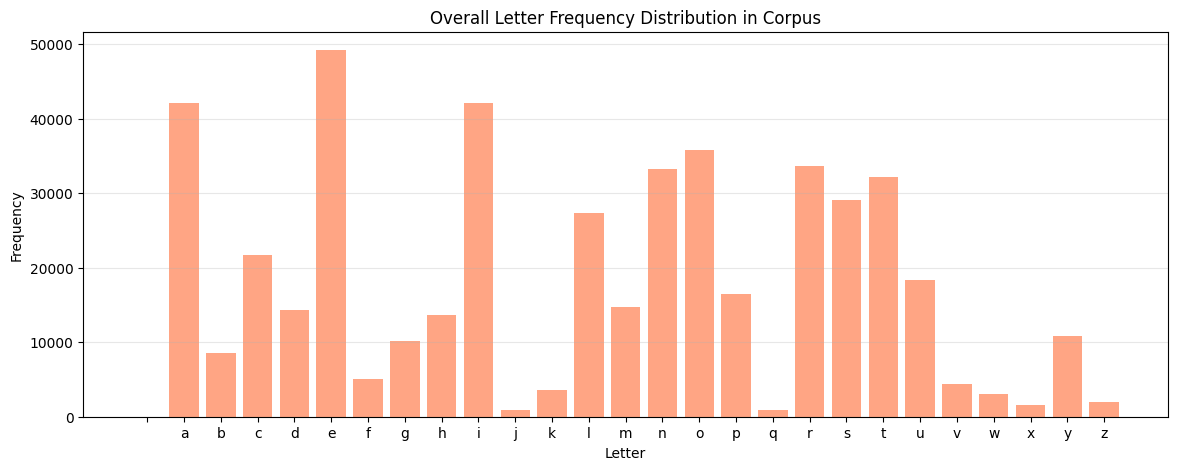

Top 10 most common letters:
e: 49224
a: 42110
i: 42068
o: 35829
r: 33619
n: 33314
t: 32191
s: 29044
l: 27406
c: 21718


In [7]:
# Visualize overall letter frequencies
letters = sorted(hmm.letter_freq.keys())
frequencies = [hmm.letter_freq[l] for l in letters]

plt.figure(figsize=(14, 5))
plt.bar(letters, frequencies, color='coral', alpha=0.7)
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.title('Overall Letter Frequency Distribution in Corpus')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Top 10 most common letters:")
for letter, freq in hmm.letter_freq.most_common(10):
    print(f"{letter}: {freq}")

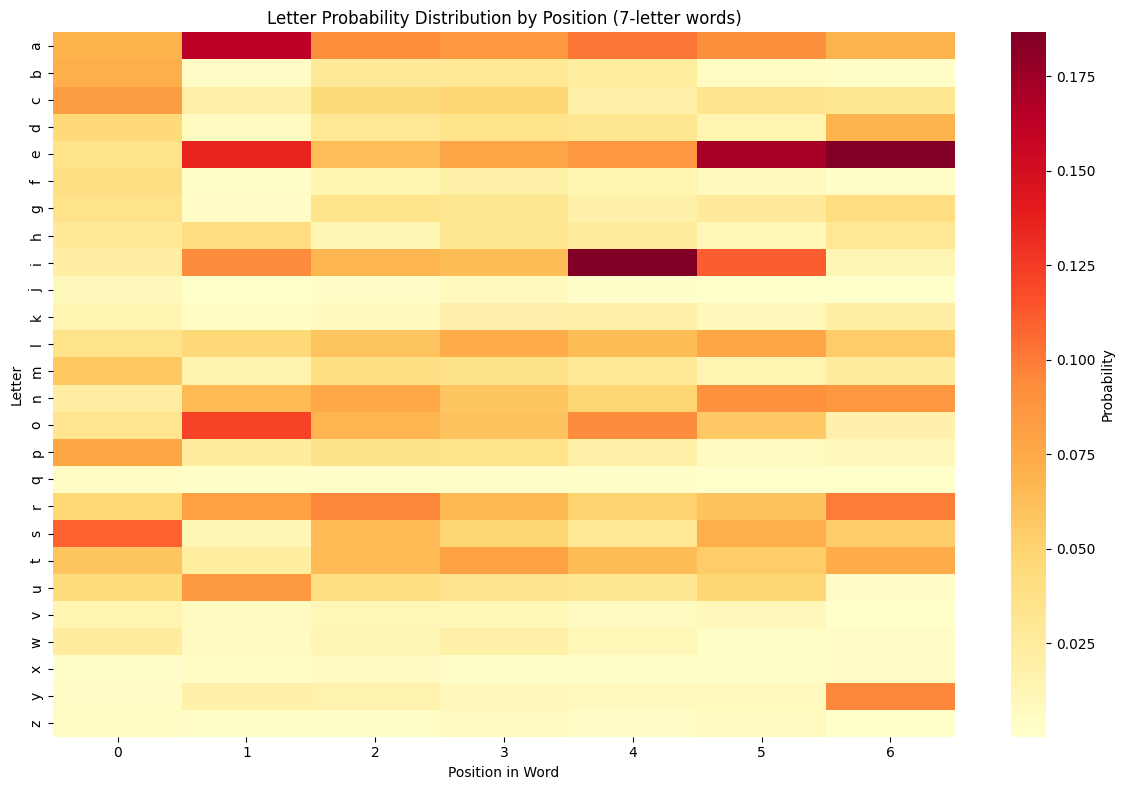

In [8]:
# Visualize position-based frequencies for a specific word length
word_length = 7  # Example: 7-letter words

if word_length in hmm.position_freq:
    # Create a matrix of letter probabilities at each position
    letters = list('abcdefghijklmnopqrstuvwxyz')
    positions = list(range(word_length))
    
    matrix = np.zeros((len(letters), word_length))
    for i, letter in enumerate(letters):
        for pos in positions:
            matrix[i, pos] = hmm.position_freq[word_length][pos].get(letter, 0)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, xticklabels=positions, yticklabels=letters, 
                cmap='YlOrRd', cbar_kws={'label': 'Probability'})
    plt.xlabel('Position in Word')
    plt.ylabel('Letter')
    plt.title(f'Letter Probability Distribution by Position ({word_length}-letter words)')
    plt.tight_layout()
    plt.show()
else:
    print(f"No data for {word_length}-letter words")

In [9]:
# Analyze most common bigrams
print("Top 20 most common bigrams:")
bigram_list = []
for first in hmm.bigram_freq:
    for second in hmm.bigram_freq[first]:
        bigram_list.append((first + second, hmm.bigram_freq[first][second]))

bigram_list.sort(key=lambda x: x[1], reverse=True)
for bigram, prob in bigram_list[:20]:
    print(f"{bigram}: {prob:.4f}")

Top 20 most common bigrams:
 r: 1.0000
qu: 0.8895
ve: 0.5188
ze: 0.4174
ke: 0.3465
de: 0.2565
ju: 0.2431
ja: 0.2383
di: 0.2302
ti: 0.2286
ma: 0.2243
wa: 0.2234
er: 0.2212
un: 0.2199
bl: 0.2140
te: 0.2116
he: 0.2105
vi: 0.2010
le: 0.2009
st: 0.1994


## 5. Test the HMM with Example Cases

In [10]:
def test_hmm_prediction(hmm, word, guessed_letters, num_top=10):
    """
    Test HMM prediction for a given word state.
    """
    # Create masked word
    masked_word = ''.join([c if c in guessed_letters else '_' for c in word])
    
    print(f"\nActual word: {word}")
    print(f"Masked word: {masked_word}")
    print(f"Guessed letters: {sorted(guessed_letters)}")
    
    # Get predictions
    probs = hmm.predict_letter_probabilities(masked_word, guessed_letters)
    
    # Sort by probability
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop {num_top} predicted letters:")
    for i, (letter, prob) in enumerate(sorted_probs[:num_top], 1):
        in_word = '✓' if letter in word else '✗'
        print(f"{i}. {letter}: {prob:.4f} {in_word}")
    
    # Check if best guess is in the word
    best_guess = sorted_probs[0][0]
    return best_guess in word

In [11]:
# Test case 1: Beginning of game
print("="*60)
print("Test Case 1: Start of game")
print("="*60)
test_hmm_prediction(hmm, 'apple', set(), num_top=10)

Test Case 1: Start of game

Actual word: apple
Masked word: _____
Guessed letters: []

Top 10 predicted letters:
1. a: 0.0886 ✓
2. e: 0.0845 ✓
3. o: 0.0633 ✗
4. r: 0.0630 ✗
5. i: 0.0621 ✗
6. s: 0.0531 ✗
7. n: 0.0531 ✗
8. l: 0.0528 ✓
9. t: 0.0522 ✗
10. u: 0.0464 ✗


True

In [12]:
# Test case 2: Partially revealed word
print("="*60)
print("Test Case 2: Partially revealed word")
print("="*60)
test_hmm_prediction(hmm, 'apple', set('ae'), num_top=10)

Test Case 2: Partially revealed word

Actual word: apple
Masked word: a___e
Guessed letters: ['a', 'e']

Top 10 predicted letters:
1. i: 0.1221 ✗
2. l: 0.1168 ✓
3. n: 0.0831 ✗
4. o: 0.0715 ✗
5. r: 0.0640 ✗
6. u: 0.0564 ✗
7. d: 0.0543 ✗
8. g: 0.0498 ✗
9. s: 0.0463 ✗
10. b: 0.0372 ✗


False

In [13]:
# Test case 3: Nearly complete word
print("="*60)
print("Test Case 3: Nearly complete word")
print("="*60)
test_hmm_prediction(hmm, 'apple', set('aple'), num_top=10)

Test Case 3: Nearly complete word

Actual word: apple
Masked word: apple
Guessed letters: ['a', 'e', 'l', 'p']

Top 10 predicted letters:
1. i: 0.0690 ✗
2. o: 0.0635 ✗
3. r: 0.0615 ✗
4. n: 0.0612 ✗
5. t: 0.0602 ✗
6. s: 0.0575 ✗
7. c: 0.0510 ✗
8. u: 0.0481 ✗
9. m: 0.0448 ✗
10. d: 0.0445 ✗


False

In [14]:
# Test case 4: Random corpus word
import random
random.seed(42)

print("="*60)
print("Test Case 4: Random corpus word")
print("="*60)
test_word = random.choice(corpus)
test_hmm_prediction(hmm, test_word, set(), num_top=10)

Test Case 4: Random corpus word

Actual word: humanitarianize
Masked word: _______________
Guessed letters: []

Top 10 predicted letters:
1. e: 0.0763 ✓
2. i: 0.0761 ✓
3. a: 0.0716 ✓
4. o: 0.0709 ✗
5. t: 0.0665 ✓
6. n: 0.0645 ✓
7. r: 0.0638 ✓
8. s: 0.0582 ✗
9. l: 0.0552 ✗
10. c: 0.0510 ✗


True

## 6. Evaluate HMM Performance on Test Set

In [15]:
def simulate_game(hmm, word, max_wrong_guesses=6, verbose=False):
    """
    Simulate a complete Hangman game using the HMM.
    """
    word = word.lower()
    guessed_letters = set()
    wrong_guesses = 0
    repeated_guesses = 0
    
    while wrong_guesses < max_wrong_guesses:
        # Create masked word
        masked_word = ''.join([c if c in guessed_letters else '_' for c in word])
        
        if '_' not in masked_word:
            # Won!
            if verbose:
                print(f"Won! Word: {word}, Wrong guesses: {wrong_guesses}, Repeated: {repeated_guesses}")
            return True, wrong_guesses, repeated_guesses
        
        # Get best guess from HMM
        guess = hmm.get_best_guess(masked_word, guessed_letters)
        
        # Check for repeated guess (shouldn't happen with our implementation)
        if guess in guessed_letters:
            repeated_guesses += 1
            if verbose:
                print(f"Repeated guess: {guess}")
            continue
        
        guessed_letters.add(guess)
        
        if guess not in word:
            wrong_guesses += 1
            if verbose:
                print(f"Wrong guess: {guess} (Total wrong: {wrong_guesses})")
    
    # Lost
    if verbose:
        print(f"Lost! Word: {word}, Wrong guesses: {wrong_guesses}, Repeated: {repeated_guesses}")
    return False, wrong_guesses, repeated_guesses

In [16]:
# Load test set
with open('data/test.txt', 'r') as f:
    test_words = [word.strip().lower() for word in f.readlines()]

print(f"Loaded {len(test_words)} test words")
print(f"Sample test words: {test_words[:10]}")

Loaded 2000 test words
Sample test words: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


In [ ]:
# Evaluate on a sample of test set (or full set if desired)
print("Evaluating HMM on test set...")
print("This may take a few minutes...\n")

num_test_games = min(2000, len(test_words))  # Evaluate on up to 2000 games
test_sample = test_words[:num_test_games]

wins = 0
total_wrong_guesses = 0
total_repeated_guesses = 0

results = []

for i, word in enumerate(test_sample):
    won, wrong, repeated = simulate_game(hmm, word, max_wrong_guesses=6)
    
    if won:
        wins += 1
    
    total_wrong_guesses += wrong
    total_repeated_guesses += repeated
    results.append((word, won, wrong, repeated))
    
    if (i + 1) % 200 == 0:
        print(f"Progress: {i+1}/{num_test_games} games completed")

print("\n" + "="*60)
print("HMM EVALUATION RESULTS")
print("="*60)

Evaluating HMM on test set...
This may take a few minutes...

Progress: 200/2000 games completed
Progress: 400/2000 games completed
Progress: 600/2000 games completed
Progress: 800/2000 games completed
Progress: 1000/2000 games completed


In [ ]:
# Calculate metrics
success_rate = wins / num_test_games
avg_wrong_guesses = total_wrong_guesses / num_test_games
avg_repeated_guesses = total_repeated_guesses / num_test_games

# Calculate score using the formula from the problem statement
final_score = (success_rate * num_test_games) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)

print(f"\nGames Played: {num_test_games}")
print(f"Games Won: {wins}")
print(f"Success Rate: {success_rate:.2%}")
print(f"\nTotal Wrong Guesses: {total_wrong_guesses}")
print(f"Avg Wrong Guesses per Game: {avg_wrong_guesses:.2f}")
print(f"\nTotal Repeated Guesses: {total_repeated_guesses}")
print(f"Avg Repeated Guesses per Game: {avg_repeated_guesses:.2f}")
print(f"\n{'='*60}")
print(f"FINAL SCORE: {final_score:.2f}")
print(f"{'='*60}")

In [ ]:
# Analyze results by word length
results_df = pd.DataFrame(results, columns=['word', 'won', 'wrong_guesses', 'repeated_guesses'])
results_df['word_length'] = results_df['word'].apply(len)

print("\nPerformance by Word Length:")
length_stats = results_df.groupby('word_length').agg({
    'won': ['count', 'sum', 'mean'],
    'wrong_guesses': 'mean',
    'repeated_guesses': 'mean'
})
print(length_stats)

In [ ]:
# Visualize performance by word length
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Success rate by length
length_success = results_df.groupby('word_length')['won'].mean()
axes[0, 0].bar(length_success.index, length_success.values, color='green', alpha=0.7)
axes[0, 0].set_xlabel('Word Length')
axes[0, 0].set_ylabel('Success Rate')
axes[0, 0].set_title('Success Rate by Word Length')
axes[0, 0].grid(axis='y', alpha=0.3)

# Average wrong guesses by length
length_wrong = results_df.groupby('word_length')['wrong_guesses'].mean()
axes[0, 1].bar(length_wrong.index, length_wrong.values, color='red', alpha=0.7)
axes[0, 1].set_xlabel('Word Length')
axes[0, 1].set_ylabel('Avg Wrong Guesses')
axes[0, 1].set_title('Average Wrong Guesses by Word Length')
axes[0, 1].grid(axis='y', alpha=0.3)

# Distribution of wrong guesses
axes[1, 0].hist(results_df['wrong_guesses'], bins=7, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Wrong Guesses per Game')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Wrong Guesses')
axes[1, 0].grid(axis='y', alpha=0.3)

# Win/Loss distribution
win_loss_counts = results_df['won'].value_counts()
axes[1, 1].bar(['Lost', 'Won'], [win_loss_counts.get(False, 0), win_loss_counts.get(True, 0)], 
               color=['red', 'green'], alpha=0.7)
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Win/Loss Distribution')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save the Trained Model

In [ ]:
# Save the model for use in Part 2 (RL agent)
hmm.save_model('hmm_model.pkl')
print("Model saved successfully!")

## 8. Summary and Key Findings

### HMM Design:
- **Hidden States**: Letter identities at each position in the word
- **Emissions**: The observed masked pattern (e.g., '_pp_e')
- **Key Components**:
  1. Position-based letter frequency distributions
  2. Bigram and trigram transition probabilities
  3. Pattern matching against corpus
  4. Overall letter frequency statistics

### Strategy:
The HMM combines multiple information sources:
1. **Pattern Matching (50% weight)**: Finds words in corpus matching current pattern
2. **Position-based Probabilities (20% weight)**: Uses position-specific letter frequencies
3. **N-gram Context (20% weight)**: Leverages bigram/trigram patterns
4. **Overall Frequency (10% weight)**: Falls back to common letters

### Performance:
- The HMM provides probability distributions for the RL agent to use
- Success rate and efficiency metrics are shown above
- The model handles different word lengths and game states effectively

### Next Steps (Part 2):
The RL agent will use these probability distributions as part of its state representation to make optimal guessing decisions.